#**IMPORTING LIBRARIES**

In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
from numpy import array
from numpy import asarray
from numpy import zeros


In [97]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [98]:
pip install simpletransformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:


from simpletransformers.classification import ClassificationModel
import pandas as pd



In [100]:


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)



#**LOADING DATASET**

In [101]:
import pandas as pd
df=pd.read_csv('/content/manglish_dataset.csv')
df

,comments,status,rating
0,'Super ️️ waiting for upcoming bharanam’,positive,4
1,"'India maharajyathil keralam mathram alla, bt ...",negative,2
2,Make in Kerala,positive,3
3,Hats off Hibi Eden for promoting menstrual cup...,positive,4
4,Parasyathiny aano 10 crores,negative,1
...,...,...,...
1092,മാർഗം ഒന്നേയുള്ളുലണ്ടൻ വരെ പോയി ദുബായ് വഴി വന്...,positive,2
1093,"E-rashtriya netakkalude swathukal kanduketi, a...",negative,5
1094,കൂട്ട ആത്മഹത്യ ചെയ്യാതെ കുടുംബം വേണമെങ്കിൽ മാർ...,negative,4
1095,Good debate 👍👍👌👍,negative,2


#EDA

In [102]:
# getting the shape of the data
df.shape

(1097, 3)

In [103]:
df.tail(10)

,comments,status,rating
1087,എന്താ ശരിയല്ലേ താങ്കള്‍ ഈ കേരളത്തില്‍ തന്നെ അല...,negative,0
1088,Cpm um bj pum തമ്മിലുള്ള ഒത്തു കളി.. ഭരണം മാറാ...,negative,5
1089,Cpm um bj pum തമ്മിലുള്ള ഒത്തു കളി.. ഭരണം മാറാ...,neutral,2
1090,സി പി എമ്മും UDF ഉം KJP യും എല്ലാം ഒന്നു തന്നെ...,negative,0
1091,അടുത്ത ഓണം വരെ ഭരണം ഉണ്ടായാൽ ഒരു കാലി കിറ്റ് അ...,neutral,1
1092,മാർഗം ഒന്നേയുള്ളുലണ്ടൻ വരെ പോയി ദുബായ് വഴി വന്...,positive,2
1093,"E-rashtriya netakkalude swathukal kanduketi, a...",negative,5
1094,കൂട്ട ആത്മഹത്യ ചെയ്യാതെ കുടുംബം വേണമെങ്കിൽ മാർ...,negative,4
1095,Good debate 👍👍👌👍,negative,2
1096,എണ്ണ വില കുറക്കും എന്ന് പറഞ്ഞിട്ട് ഒറ്റയടിക്ക്...,negative,4


In [104]:
df.head()

,comments,status,rating
0,'Super ️️ waiting for upcoming bharanam’,positive,4
1,"'India maharajyathil keralam mathram alla, bt ...",negative,2
2,Make in Kerala,positive,3
3,Hats off Hibi Eden for promoting menstrual cup...,positive,4
4,Parasyathiny aano 10 crores,negative,1


In [105]:
# describing the data set
df.describe()

,rating
count,1097.000000
mean,2.423883
std,1.687193
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,5.000000


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  1093 non-null   object
 1   status    1097 non-null   object
 2   rating    1097 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.8+ KB


In [107]:
# checking if there is any null data or not
df.isnull().any()

comments     True
status      False
rating      False
dtype: bool

In [108]:
for i in df.columns:
  print(i,df[i].unique()) 

comments ["'Super ️️ waiting for upcoming bharanam’"
 "'India maharajyathil keralam mathram alla, bt ithrem kattumudipikana vere oru nethakanmar indavilla’"
 'Make in Kerala'
 'Hats off Hibi Eden for promoting menstrual cup throughout the State.'
 'Parasyathiny aano 10 crores' 'ഇമ്മാതിരി കിഴങ്ങ് മന്ത്രി'
 'Cyber security oke enthinanu cheyunathu ?'
 'Sarkkaar Udyogastharude Salariyude 20% Coupons aayi nalkuka.'
 "Kerala budget will be beneficial for Bengali youth because malayali youths don't want to stay in Kerala."
 'ldf vanu ellam sheriyay'
 'ലോകത്തു ഇത്രയും തല്ലിപ്പൊളി ഒരു സര്ക്കാര് ഉണ്ടായിട്ടില്ല'
 'Kerala should be made a hub of Vazhakkula Doctorate.'
 'India may be utilised by the help of Adani for our future lives and namaste to all of us and to Sri Adani.'
 'K budget adipoli'
 'During election people of kerala saw your performance.'
 'State funds totally mismanaged and misused by government.'
 'Central budget nalla budget anu moyanth anchore....'
 'GST നല്ലത് തന്നെയാണ്' 'Petro

In [109]:
df.columns

Index(['comments', 'status', 'rating'], dtype='object')

#**DATA VISUALIZATION**

<Axes: xlabel='rating', ylabel='count'>

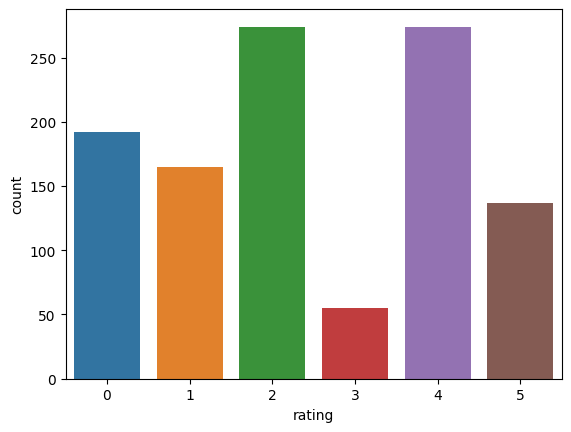

In [110]:
import seaborn as sns
sns.countplot(x='rating',data=df)

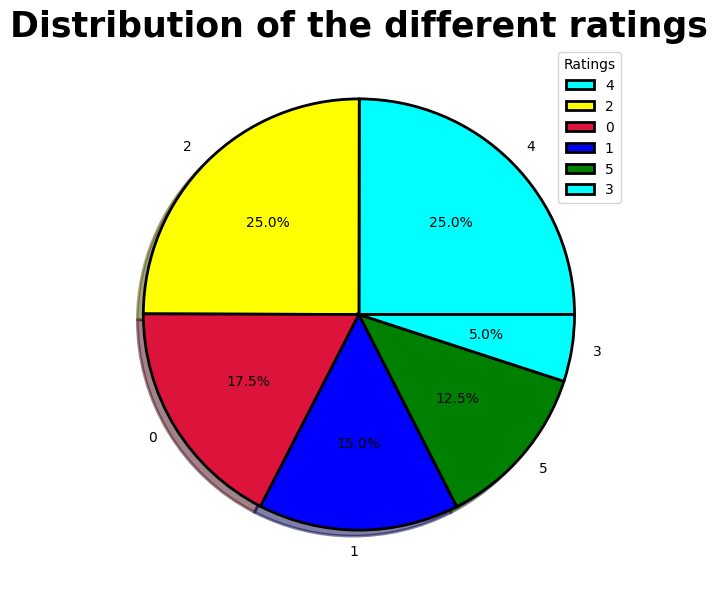

In [111]:
fig=plt.figure(figsize=(7,7))
colors=("cyan","yellow","crimson","blue","green")
wp={'linewidth':2,'edgecolor':"black"}
explode=(0.1,0.1,0.1,0.1,0)
tags=df['rating'].value_counts()
tags.plot(kind='pie',autopct="%1.1f%%",label='',colors=colors,shadow=True,wedgeprops=wp)
plt.legend(title="Ratings")
plt.title('Distribution of the different ratings',fontsize='25',fontweight='bold')
plt.show()

In [112]:
df['status'].value_counts()

negative    562
positive    338
neutral     197
Name: status, dtype: int64

Text(0, 0.5, 'Status')

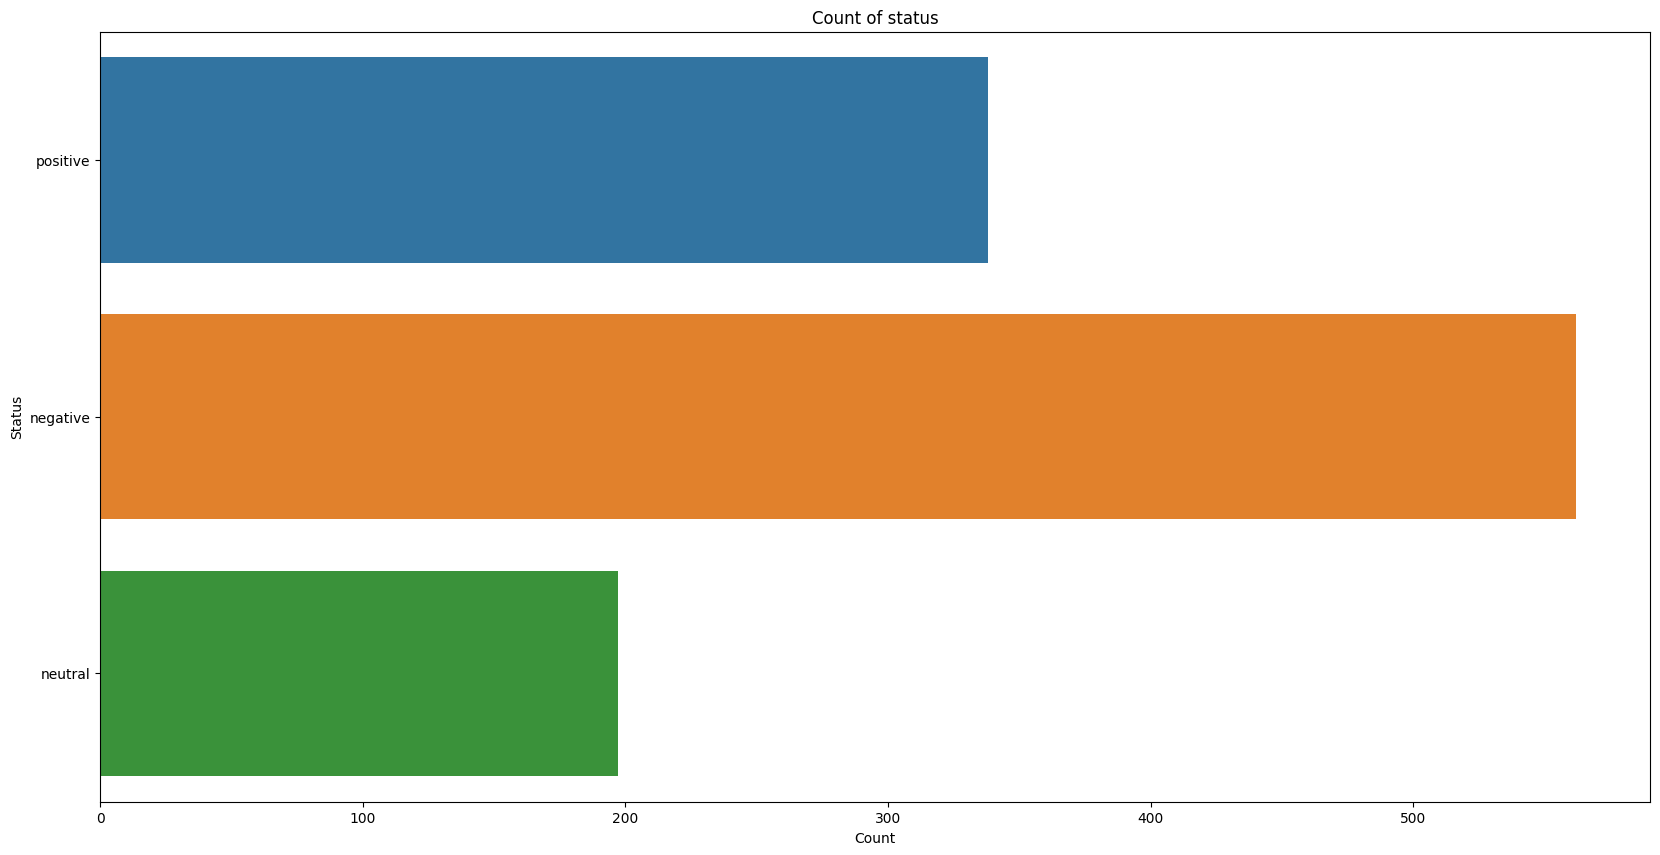

In [113]:
fig=plt.figure(figsize=(20,10)) 
sns.countplot(y='status',data=df)
plt.title("Count of status")
plt.xlabel("Count")
plt.ylabel("Status")

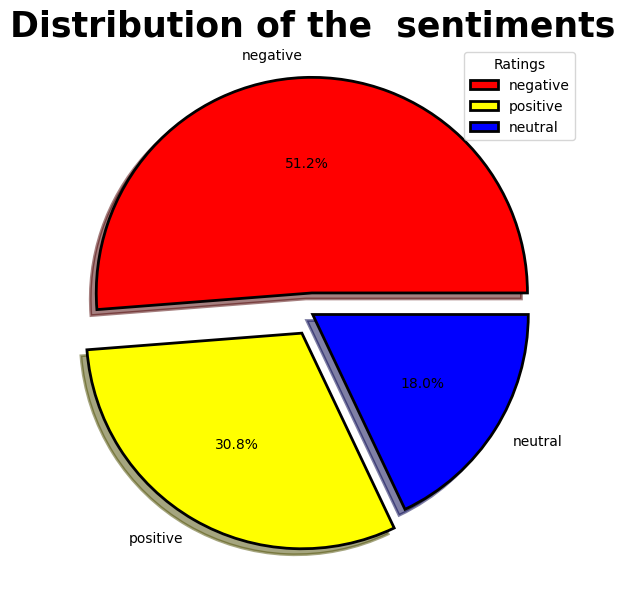

In [114]:
fig=plt.figure(figsize=(7,7))
colors=("red","yellow",'blue')
wp={'linewidth':2,'edgecolor':"black"}
explode=(0.1,0.1,0)
tags=df['status'].value_counts()
tags.plot(kind='pie',autopct="%0.1f%%",label='',colors=colors,explode=explode,shadow=True,wedgeprops=wp)
plt.legend(title="Ratings")
plt.title('Distribution of the  sentiments',fontsize='25',fontweight='bold')
plt.show()

In [115]:


pos_sentiment= df[df.status=='negative']
pos_sentiment.head()

,comments,status,rating
1,"'India maharajyathil keralam mathram alla, bt ...",negative,2
4,Parasyathiny aano 10 crores,negative,1
5,ഇമ്മാതിരി കിഴങ്ങ് മന്ത്രി,negative,1
10,ലോകത്തു ഇത്രയും തല്ലിപ്പൊളി ഒരു സര്ക്കാര് ഉണ്ട...,negative,0
11,Kerala should be made a hub of Vazhakkula Doct...,negative,1


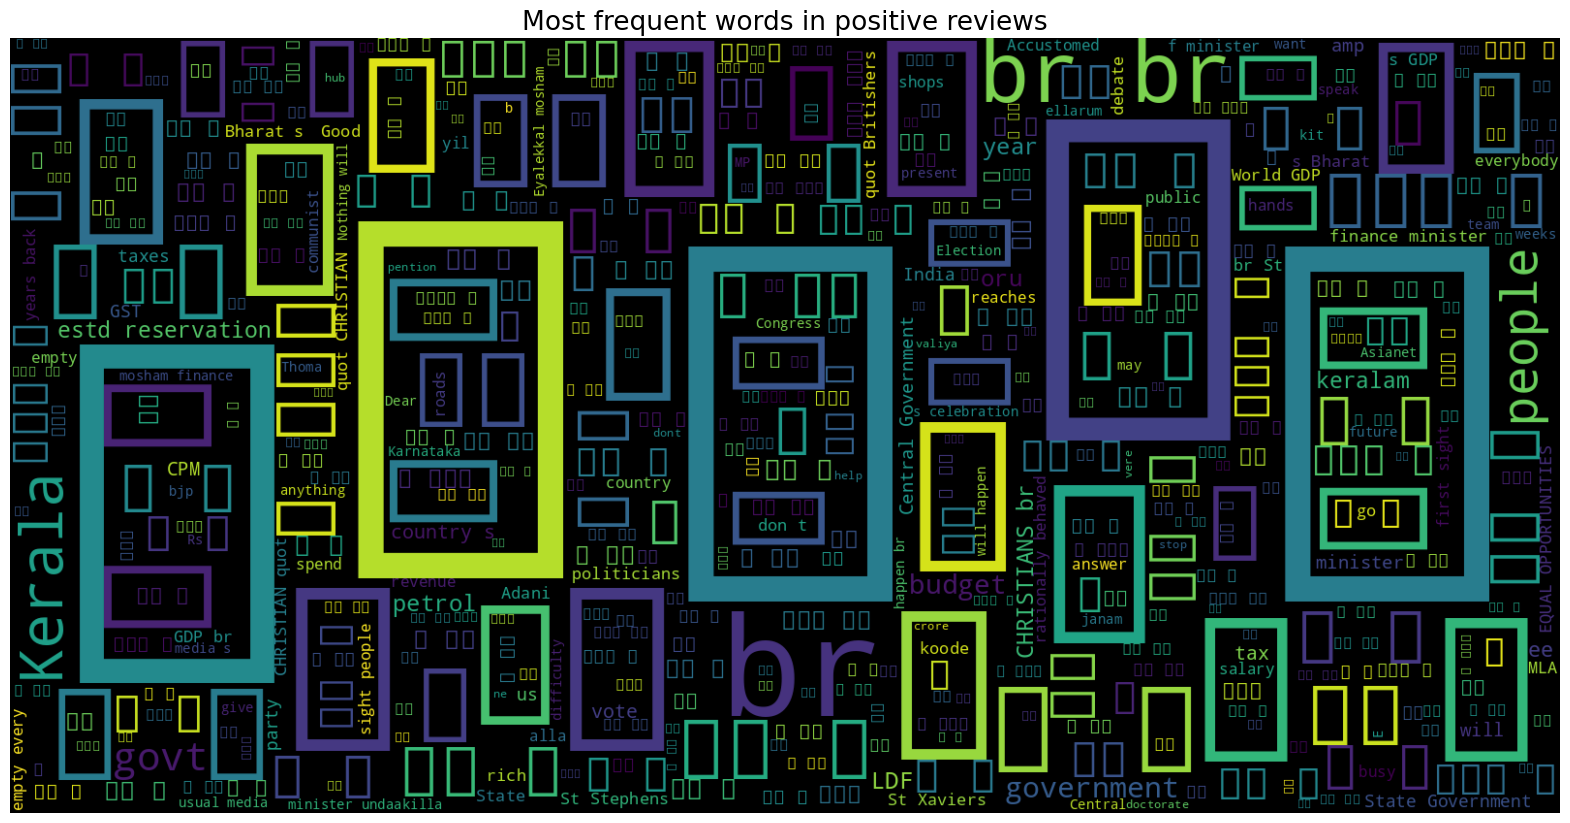

In [116]:
from wordcloud import WordCloud

text = ' '.join([word for word in pos_sentiment['comments']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews', fontsize=19)
plt.show()



In [117]:
df.drop('rating',axis=1,inplace=True)



In [118]:
df.isnull().sum()

comments    4
status      0
dtype: int64

In [119]:
df['comments']=df['comments'].fillna('ldf vanu ellam sheriyaki')

#Translate & Transliterating the dataset

In [120]:
pip install googletrans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [121]:
!pip install mtranslate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
pip install  indic_transliteration

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
import pandas as pd
from mtranslate import translate
from indic_transliteration import sanscript



# Function to translate and transliterate a single text
def translate_transliterate(text):
    # Translate the text from Malayalam to English
    translated_text = translate(text, 'en', 'ml')

    # Transliterate the translated text to English characters
    transliterated_text = sanscript.transliterate(translated_text, sanscript.MALAYALAM, sanscript.ITRANS)

    return transliterated_text

# Apply translation and transliteration to the 'comments' column
df['comments'] = df['comments'].fillna('ldf vanu ellam sheriyaki')
df['comments'] = df['comments'].apply(lambda x: translate_transliterate(x) if pd.notnull(x) else x)



print(df)









                                               comments    status
0              'Super ️️ waiting for upcoming bharanam'  positive
1     'India maharajyathil keralam mathram alla, bt ...  negative
2                                        Make in Kerala  positive
3     Hats off Hibi Eden for promoting menstrual cup...  positive
4                           Parasyathiny aano 10 crores  negative
...                                                 ...       ...
1092  The only way is to go to London and come via D...  positive
1093  E-rashtriya netakkalude swathukal kanduketi, a...  negative
1094  If you want a family without committing mass s...  negative
1095                                   Good debate 👍👍👌👍  negative
1096  They said that the price of oil will be reduce...  negative

[1097 rows x 2 columns]


#Data Cleaning

##Emoji & emoticons replacing

In [124]:
#find emoticons in a dataset
def check_smileys(text):
  smiley_regex = r"(?:X|:|;|=)(?:-)?(?:\)|\(|O|D|P)"
  return len(re.findall(smiley_regex, text)) > 0

# Add a new column to the dataset indicating if there are Emoticons in the review
df["has_smileys"] = df["comments"].apply(check_smileys)

# Print the first 5 rows of the updated dataset
smiley_reviews = df[df['has_smileys'] == True]
print(smiley_reviews.head())

                                              comments    status  has_smileys
381  This story came to mind when I thought about t...  positive         True
932  Finance Minister's &#39;Financial Expertise&#3...  positive         True


In [125]:
#finding the emoji's Smilies by importing counter
from collections import Counter
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def extract_emojis(text):
    return re.findall(emoji_pattern, text)

emojis = []
for text in df['comments']:
    emojis += extract_emojis(text)

emoji_frequency = Counter(emojis)

print(emoji_frequency)

Counter({'😂': 11, '😡': 6, '🏻': 6, '🙏': 6, '😜😜😜': 6, '😂😂😂': 5, '😂😂😂😂': 5, '😉😉😜': 5, '😄': 4, '🙄': 4, '😂😂': 4, '😀': 3, '👏': 3, '😁': 3, '😅': 3, '😭': 3, '😌': 2, '😜': 2, '😁😁😁': 2, '👌': 2, '♥️♥️': 2, '😏😏😏': 2, '🙏👍': 2, '🙈': 2, '😂😂😂😂😂': 2, '🙏🙏🙏🙏': 2, '😡😡': 2, '👍👍👌👍': 2, '😄😄😄': 2, '⚖️': 2, '😆😆😆': 2, '😳': 2, '️️': 1, '🌹': 1, '😘': 1, '😍': 1, '❣️🙏': 1, '👹👹👹👹👹👹👹👹👹👹👹': 1, '👍': 1, '😜😛😍😆😁😀': 1, '😝😃😄': 1, '❤❤❤': 1, '😭😭😝': 1, '😔☹': 1, '😂😂😂😂😂😂😂': 1, '👍👍👍👍👍': 1, '❓': 1, '😀😀😀': 1, '☺️❤️😍': 1, '♥️': 1, '😃': 1, '✍': 1, '😐': 1, '👍🏻👌': 1, '😀😁': 1, '😊': 1, '💪': 1, '😜😜😜😜😜': 1, '😍😍': 1, '🙏🙏💪💪': 1, '💥💥💥': 1, '🏻👍': 1, '👏👏👏': 1, '😂😢😅': 1, '😄😄😄😄😄': 1, '👍🏻': 1, '😤😤😤': 1, '👍🙏🙏': 1, '😎': 1, '😔😔': 1, '😈😈😈😈': 1, '💪💪💪': 1, '😡😡😡😡😡😡😡😡': 1, '😢👏': 1, '😔': 1, '👍🙏': 1, '😢😅😅😅': 1, '😢': 1, '❤❤': 1, '🙄🙄🙄': 1, '😭😭😭😭😭': 1, '😂😂😂😂😂😂😂😂': 1, '😱😪': 1, '😄😄😄😄': 1, '🎁': 1, '✨️': 1, '💖': 1, '😝😝😝😝😝': 1, '😁😁': 1, '❣️': 1, '☺️': 1, '💯': 1})


In [126]:

# import emoji 
UNICODE_EMOJI = {'😂':'smiling with tears','😡':'angry mood','🏻':'why','🙏':'thanking','😜':'winking face', '😂':'smiling with tears','😉':'winking face','😄':'shaming','🙄':'thinking',
                 '😀':'just smiling','👏':'clapping','😁':'grinning face with smiling eyes','😅':'smiling face with open mouth','😭':'crying','😌':'shaming face','😜':'face with stuckout tongue',
                 '👌':'super','♥️':'red love','😏':'smirking face','👍':'ok','😳':'flushed face','🌹':'red rose','😘':'kisses',
                 '😍':'smiling face with loving eyes','❣️':'love','👹':'japanese ogre', '❓':'questioning','✍':'writing','💪':'showing muscles','💥':'blasting bomb',
                 '😤':'face with look of triumph','😎':'relaxed','😱':'wow','🎁':'gift','💖':'love', '💯':'hundred percentage','✨️':'sparkles'}
# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, ' '+"_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split())+' ')
    return text

# Function for converting emoticons into word
EMOTICONS_EMO = {':)':'Happy or smiling face', ':-)':'Happy or smiling face',';)':'Winking face',';-)':'Winking face', ':(':'Sad face', ':-(':'Sad face', ':-D':'Grinning face with a big smile', ':D':'Grinning face with a big smile'}
def convert_emoticons(text):
    for i,v in EMOTICONS_EMO.items():
        if i in text:
            text = text.replace(i,"_".join(v.replace(",","").split()))
            break
    return text

In [127]:
df["cleaned_comments"]=df["comments"].apply(convert_emojis)
df["cleaned_comments"]=df["comments"].apply(convert_emoticons)

In [128]:
#check if all emoticons are replaced
df[df['has_smileys'] == True]
print('All Emoticons are Replaced')

All Emoticons are Replaced


**Stemming and cleaning using ReGex**

In [129]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

#model building and splitting
import nltk
nltk.download('stopwords')
corpus = []
for i in range(0, 1097):
    review = re.sub('[^a-zA-Z]', ' ', df['cleaned_comments'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)
corpus
df['cleaned_comments']=corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
df

,comments,status,has_smileys,cleaned_comments
0,'Super ️️ waiting for upcoming bharanam',positive,False,super wait upcom bharanam
1,"'India maharajyathil keralam mathram alla, bt ...",negative,False,india maharajyathil keralam mathram alla bt it...
2,Make in Kerala,positive,False,make kerala
3,Hats off Hibi Eden for promoting menstrual cup...,positive,False,hat hibi eden promot menstrual cup throughout ...
4,Parasyathiny aano 10 crores,negative,False,parasyathini aano crore
...,...,...,...,...
1092,The only way is to go to London and come via D...,positive,False,way go london come via dubai
1093,"E-rashtriya netakkalude swathukal kanduketi, a...",negative,False,e rashtriya netakkalud swathuk kanduketi avark...
1094,If you want a family without committing mass s...,negative,False,want famili without commit mass suicid leav ke...
1095,Good debate 👍👍👌👍,negative,False,good debat


In [131]:
df=df.drop(['comments','has_smileys'],axis=1)

In [132]:
df

,status,cleaned_comments
0,positive,super wait upcom bharanam
1,negative,india maharajyathil keralam mathram alla bt it...
2,positive,make kerala
3,positive,hat hibi eden promot menstrual cup throughout ...
4,negative,parasyathini aano crore
...,...,...
1092,positive,way go london come via dubai
1093,negative,e rashtriya netakkalud swathuk kanduketi avark...
1094,negative,want famili without commit mass suicid leav ke...
1095,negative,good debat


#**TfidfVectorization**

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 2500)

#**Data Splitting**

In [134]:
x = tfidf.fit_transform(corpus).toarray()
#The resulting x matrix will contain the count of each word in the corpus data, and the y array will contain the target values.
tfidf.vocabulary_

{'super': 2061,
 'wait': 2412,
 'upcom': 2263,
 'bharanam': 323,
 'india': 989,
 'maharajyathil': 1284,
 'keralam': 1096,
 'mathram': 1356,
 'alla': 96,
 'bt': 393,
 'vere': 2361,
 'oru': 1512,
 'make': 1289,
 'kerala': 1095,
 'promot': 1656,
 'menstrual': 1377,
 'throughout': 2155,
 'state': 2010,
 'aano': 17,
 'crore': 631,
 'potato': 1595,
 'minist': 1386,
 'secur': 1879,
 'cheyunathu': 499,
 'sarkkaar': 1852,
 'udyogastharud': 2219,
 'salariyud': 1824,
 'aayi': 23,
 'budget': 397,
 'benefici': 311,
 'bengali': 314,
 'youth': 2493,
 'malayali': 1296,
 'want': 2414,
 'stay': 2015,
 'ldf': 1200,
 'vanu': 2308,
 'ellam': 703,
 'sheriyay': 1917,
 'never': 1453,
 'power': 1610,
 'govern': 913,
 'world': 2462,
 'made': 1277,
 'hub': 960,
 'vazhakkula': 2336,
 'doctor': 668,
 'may': 1362,
 'util': 2277,
 'help': 939,
 'adani': 45,
 'futur': 880,
 'live': 1234,
 'namast': 1432,
 'us': 2270,
 'sri': 1994,
 'adipoli': 56,
 'elect': 698,
 'peopl': 1547,
 'saw': 1861,
 'perform': 1550,
 'fund':

In [135]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['status']=le.fit_transform(df['status'])

In [136]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


We will use the GPU: Tesla T4


In [137]:
# Get the lists of lyrics and their labels.
texts = df.cleaned_comments.values
labels = df.status.values

In [138]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=3)
model.cuda()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

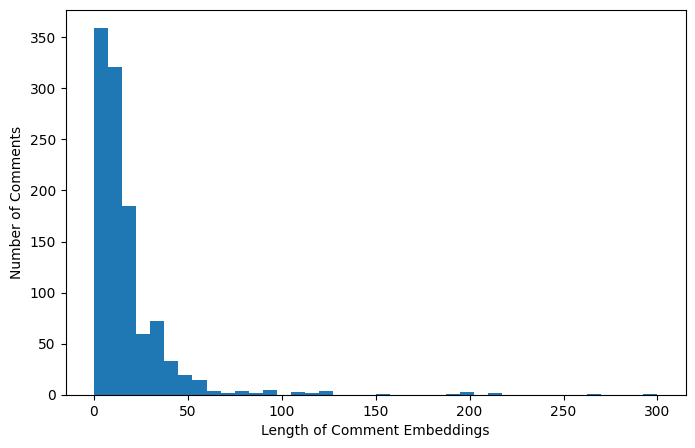

In [139]:
#to show length of embedding will be helpful to determine maximum length of comments and padding threshold
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
plot_sentence_embeddings_length(texts, tokenizer)

In [152]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [153]:
from sklearn.model_selection import train_test_split

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [154]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [155]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [156]:
optimizer = AdamW(model.parameters(),
                  lr = 8e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 2e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [157]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [158]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [159]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...

  Average training loss: 1.05
  Training epoch took: 0:00:10

======== Epoch 2 / 10 ========
Training...

  Average training loss: 1.02
  Training epoch took: 0:00:11

======== Epoch 3 / 10 ========
Training...

  Average training loss: 1.01
  Training epoch took: 0:00:09

======== Epoch 4 / 10 ========
Training...

  Average training loss: 1.00
  Training epoch took: 0:00:10

======== Epoch 5 / 10 ========
Training...

  Average training loss: 1.00
  Training epoch took: 0:00:10

======== Epoch 6 / 10 ========
Training...

  Average training loss: 1.00
  Training epoch took: 0:00:10

======== Epoch 7 / 10 ========
Training...

  Average training loss: 0.99
  Training epoch took: 0:00:10

======== Epoch 8 / 10 ========
Training...

  Average training loss: 0.99
  Training epoch took: 0:00:10

======== Epoch 9 / 10 ========
Training...

  Average training loss: 0.99
  Training epoch took: 0:00:10

======== Epoch 10 / 10 ========
Training...



In [162]:
# ========================================
#               Validation
# ========================================
# After the completion of each training epoch, measure our performance on
# our validation set.

print("")
print("Running Validation...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()

preds=[]
true=[]

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
  Accuracy: 0.51
  Validation took: 0:00:01


In [163]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [164]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions,flat_true_labels))

              precision    recall  f1-score   support

           0       1.00      0.51      0.68       219
           1       0.00      0.00      0.00         0
           2       0.01      1.00      0.03         1

    accuracy                           0.51       220
   macro avg       0.34      0.50      0.23       220
weighted avg       1.00      0.51      0.67       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [165]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from mtranslate import translate
from indic_transliteration import sanscript

def preprocess_text(text):
    # Translate the text from Malayalam to English
    translated_text = translate(text, 'en', 'ml')

    # Transliterate the translated text to English characters
    transliterated_text = sanscript.transliterate(translated_text, sanscript.MALAYALAM, sanscript.ITRANS)

    # Remove non-alphabetic characters
    transliterated_text = re.sub('[^a-zA-Z]', ' ', transliterated_text)

    # Convert to lowercase
    transliterated_text = transliterated_text.lower()

    # Tokenize the text
    words = transliterated_text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stem the words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join the preprocessed words
    preprocessed_text = ' '.join(words)

    return preprocessed_text

# Preprocess the external text
external_text = "ലോകത്തു ഇത്രയും തല്ലിപ്പൊളി ഒരു സര്ക്കാര് ഉണ്ടായിട്ടില്ല"
preprocessed_text = preprocess_text(external_text)

print(preprocessed_text)
comments1 = preprocessed_text

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

never power govern world


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [166]:


# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

if  flat_predictions[0]==0:
  print('The statement is negative')
elif flat_predictions[0]==1:
  print('The statement is positive')
else:
  print('The statement is neutral')

The statement is negative


Confusion Matrix:
[[112   0   0]
 [ 35   0   0]
 [ 72   0   1]]


<Axes: >

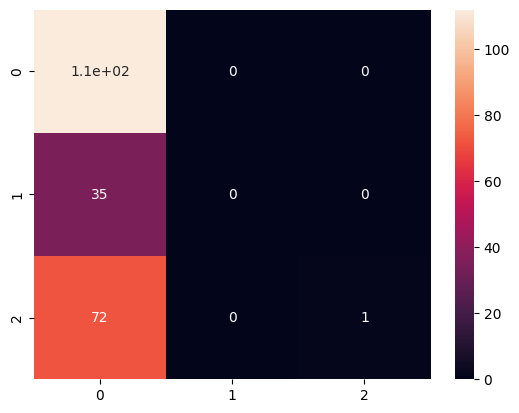

In [167]:
from sklearn.metrics import classification_report, confusion_matrix

# ...

# After training and evaluating the model

# Evaluation on validation set
predictions = []
true_labels = []

# Put model in evaluation mode
model.eval()

# Predict
for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm,annot=True)